In [1]:
# Imports
import os, sys, types
import pathlib
from importlib import reload
import pickle 

import numpy as np
import math
import scipy
import scipy.linalg
from sympy.physics.quantum import TensorProduct, tensor_product_simp
from sympy.physics.quantum.dagger import Dagger

In [2]:
import scipy.optimize

In [3]:
from functools import partial

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [7]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [8]:
import hiddenbcd
from hiddenbcd.queries import repeated_search_numerical_length, repeated_search_initial_conditions2

# Sequential protocol

Given the problem $\textsf{HBCD}(\alpha,\epsilon,\rho_h)$, the goal is to come up with a sequential protocol that solves it in the minimal number of queries. We do this by starting with $N=1$, optimizing the phase sequence $\Phi$ of this length and then checking if it matches the probability of success criteria. If not, we increment the value of $N$ and stop otherwise, outputting the value of $N$. This is illustrated in the following example by showing how the probability of success (or one minus the error probability) grows with $N$ and an appropriate query length can be chosen by choosing a desired value of $\epsilon$.

## Trend of prob of success with query length N

In [9]:
N_array = 2*np.arange(1,10)
alpha = 0.1
n_reps = 10   # Find 

p0_theta0 = np.zeros(len(N_array))
p0_theta1 = np.zeros(len(N_array))
p_error = np.zeros(len(N_array))
p_success = np.zeros(len(N_array))

for ind in range(len(N_array)):
    K = N_array[ind]
    
    # Get an optimal solution
    phi_sol, _ = repeated_search_initial_conditions2(alpha, K, n_reps)
    
    # Compute the relevant probabilities
    psi_W = phi_sol[0]
    phi = phi_sol[1:]

    # theta_V = 0
    _, rho = hiddenbcd.queries.phase_sequence(0.0, phi, psi_W, K)
    prob_theta0 = hiddenbcd.queries.probability_target(rho)
    p0_theta0[ind] = prob_theta0[0]

    # theta_V = theta_1
    _, rho = hiddenbcd.queries.phase_sequence(alpha, phi, psi_W, K)
    prob_theta1 = hiddenbcd.queries.probability_target(rho)
    p0_theta1[ind] = prob_theta1[0]
    
    # Error 
    p_error[ind] = hiddenbcd.estimators.error_majority_vote(1, phi_sol, alpha, K)

    # Success
    p_success[ind] = 1 - p_error[ind]
    
    print('Done with K=%d' %K)

Done with K=2
Done with K=4
Done with K=6
Done with K=8
Done with K=10
Done with K=12
Done with K=14
Done with K=16
Done with K=18


In [10]:
p_success

array([0.50498336, 0.53297048, 0.5884324 , 0.66366595, 0.75001326,
       0.84190048, 0.92143613, 0.97667241, 0.99945552])

0.1


Text(0, 0.5, '$p_{y|\\theta_V}(1|\\alpha)$')

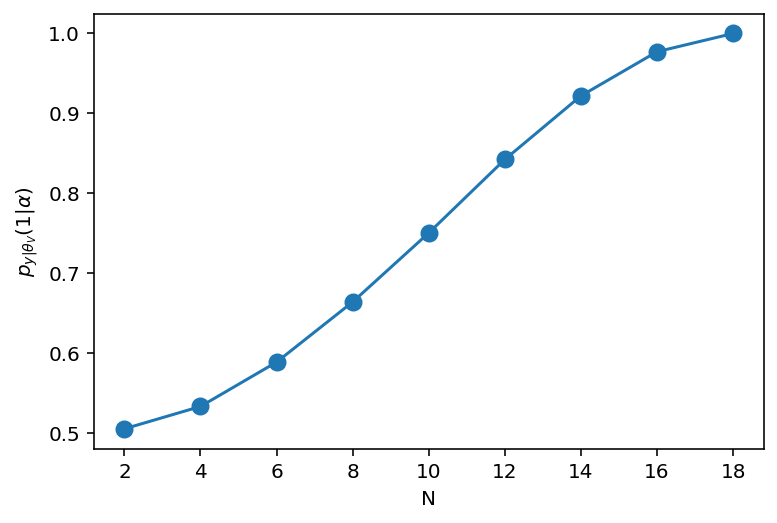

In [11]:
print(alpha)
plt.plot(N_array, p_success, '-o', markersize=8)
plt.xlabel('N')
plt.ylabel(r'$p_{y|\theta_V}(1|\alpha)$')

# savefile = 'prob_target_vs_N_alpha_0_1.png'
# plt.savefig(savefile, bbox_inches='tight', pad_inches=0, dpi=300)

# Multi-shot protocol

In this case, we are again given the problem $\textsf{HBCD}(\alpha,\epsilon,\rho_h)$. We now a fixed query depth $d$. The goal is to come up with a multi-shot protocol that uses the fewest queries or makes the lowest number of shots for a fixed $d$. 

We do this by optimizing the phase sequence $\Phi$ of length $d$ and determine the number of shots $m$ through error probability computation.

In [12]:
from scipy.stats import binom as scp_binom

In [13]:
# What are the probability vectors
def probability_vector(theta_1, angle_vec, K):
    psi_W = angle_vec[0]
    phi = angle_vec[1:]

    # theta_V = 0
    _, rho = hiddenbcd.queries.phase_sequence(0.0, phi, psi_W, K)
    prob_theta0 = hiddenbcd.queries.probability_target(rho)

    # theta_V = theta_1
    _, rho = hiddenbcd.queries.phase_sequence(theta_1, phi, psi_W, K)
    prob_theta1 = hiddenbcd.queries.probability_target(rho)
    
    return prob_theta0, prob_theta1

In [14]:
n_reps = 5   # number of random initial conditions during optimization
d_query = 3  # query depth of multi-shot protocols
theta_1 = alpha = 0.6

phi_opt, cost_opt = repeated_search_initial_conditions2(alpha, d_query, n_reps)

In [15]:
phi_opt

array([ 1.06226706e+00, -7.85398677e-01, -2.50545621e-06,  2.88587123e-06,
       -7.85398010e-01])

In [16]:
cost_opt

0.07352542615235973

In [17]:
# Note that cost_opt is 4eps^2 ... Denoting sqrt(cost_opt) as delta
delta = np.sqrt(cost_opt)
print(delta)

0.2711557230676862


In [18]:
# Majority vote for m=1 should give epsilon as answer
epsilon = hiddenbcd.estimators.error_majority_vote(1, phi_opt, alpha, d_query)
print(epsilon)

0.1355778615338431


In [19]:
delta/epsilon

2.0

In [20]:
# How many shots do we need to do for this depth and alpha values with phi_opt?
# We consider the Likelihood Ratio Test as our estimator
eps_N = 0.05

# Obtain lower bound through KL divergence
m_lb = hiddenbcd.protocols.get_nshots_for_error_success(alpha, d_query, phi_opt, eps_N, 
                                            type_estimator='lrt', FLAG_kl=True)
print(m_lb)

# Obtain an upper bound through Chernoff Information bound
m_ub = hiddenbcd.protocols.get_nshots_for_error_success(alpha, d_query, phi_opt, eps_N,
                                            type_estimator='lrt', FLAG_kl=False, FLAG_optimize_gamma=True)
print(m_ub)

2
4


In [21]:
# Above are some bound but what do we get in practice when we run an experiment on it?
# Note that we may need to repeat this multiple times to report a value with high confidence
m = hiddenbcd.protocols.get_nshots_for_error_success_experiment(alpha, d_query, phi_opt, eps_N, 
                                                    FLAG_verbose=False)
print(m)

3


In [22]:
# Let us repeat the above for a smaller value of alpha
n_reps = 5
d_blocks = 5
theta_1 = alpha = 0.25

phi_opt, cost_opt = repeated_search_initial_conditions2(alpha, d_blocks, n_reps)

epsilon = hiddenbcd.estimators.error_majority_vote(1, phi_opt, alpha, d_blocks)
print(epsilon)

# How many shots do we need to do for this d_blocks and alpha values with phi_opt?
eps_N = 0.1
m = hiddenbcd.protocols.get_nshots_for_error_success(alpha, d_blocks, phi_opt, eps_N, FLAG_odd_m=True)
print(m)

m = hiddenbcd.protocols.get_nshots_for_error_success(alpha, d_blocks, phi_opt, eps_N, FLAG_odd_m=True, type_estimator='lrt')
print(m)

0.21086817678686914
3
3


In [23]:
p_theta0, p_theta1 = probability_vector(alpha, phi_opt, d_blocks)

In [24]:
print(p_theta0)
print(p_theta1)

[2.93827855e-04 9.99706172e-01]
[0.57855747 0.42144253]


Reminder: In contrast to our paper, we try to set the measurement outcome $y=0$ with high probability when the angle corresponding to the unknown channel $C$ takes the value $\alpha$. 

The probability vectors above should be read as 
\begin{align}
& [p_{y|\theta_C}(0|0), p_{y|\theta_C}(0|\alpha)] \\
& [p_{y|\theta_C}(1|0), p_{y|\theta_C}(1|\alpha)] \\
\end{align}

In the following, we show why Likelihood Ratio Test which is the optimal estimator in this case should be preferred over the majority vote estimator.

In [25]:
# Parameters of interest
n_reps = 5
d_blocks = 5
theta_1 = alpha = 0.24

# Get optimal phases
phi_opt, cost_opt = repeated_search_initial_conditions2(alpha, d_blocks, n_reps)

# Error of majority vote
n = 100
m_array = np.arange(1,n+1)
error_math_array = np.zeros(n)
error_scp_array = np.zeros(n)

# Lower bound on error of likelihood ratio test
error_array_LRT = np.zeros(n)

# Errors we would like to achieve
ideal_error = 0.1*np.ones(n)
ideal_error2 = 0.05*np.ones(n)

for ind in range(n):
    m = m_array[ind]
    error_math_array[ind] = hiddenbcd.estimators.error_majority_vote(m, phi_opt, alpha, d_blocks, FLAG_math_compute=True)
    error_scp_array[ind] = hiddenbcd.estimators.error_majority_vote(m, phi_opt, alpha, d_blocks, FLAG_math_compute=False)
    
    error_array_LRT[ind] = hiddenbcd.estimators.error_likelihood_ratio_test(m, phi_opt, alpha, d_blocks)

Text(0, 0.5, 'Error probability for different estimators')

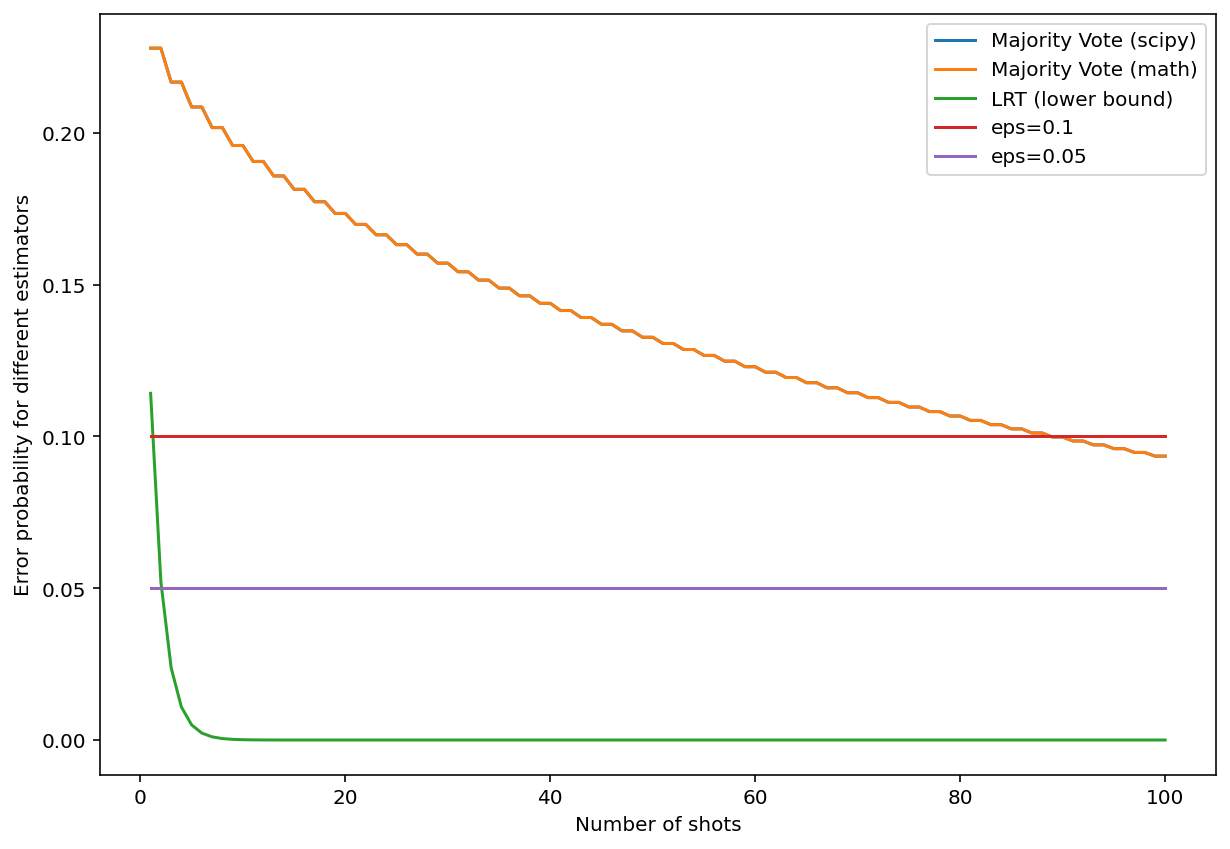

In [26]:
plt.figure(figsize=(10,7))
plt.plot(m_array, error_math_array, label='Majority Vote (scipy)')
plt.plot(m_array, error_scp_array, label='Majority Vote (math)')

plt.plot(m_array, error_array_LRT, label='LRT (lower bound)')
plt.plot(m_array, ideal_error, label='eps=0.1')
plt.plot(m_array, ideal_error2, label='eps=0.05')
# plt.plot(m_array[0::2], error_scp_array[0::2], label='odd m')
# plt.plot(m_array[1::2], error_scp_array[1::2], label='even m')
#plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Number of shots')
plt.ylabel('Error probability for different estimators')

Note that we achieve desired error probabilities with fewer number of shots when using the LRT estimator.

## First numerical experiment

In [27]:
def plot_trend(theta1_array, N_array, n_iters_end=5, FLAG_savefig=False, savefig_filename='strategy.png'):
    plt.figure(figsize=(10,7))
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['figure.titlesize'] = 22
    plt.rcParams['axes.labelsize'] = 22
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16

    plt.plot(theta1_array, N_array, '-x', c='b', markersize=8)
    #plt.plot(theta1_array, N_array_d5, '-x', c='b', markersize=8, label=r'N ($d=3,\epsilon=0.05$)')

    # Assuming theta_array is in descending order
    # Trying to find N as f(alpha)
    poly_end, cov_end = np.polyfit(np.log(theta1_array[-n_iters_end:]),
                                   np.log(N_array[-n_iters_end:]),1, cov=True)

    label_fit_end = r"slope = %0.2f $\pm$ %0.2f" % (poly_end[0], np.sqrt(np.diag(cov_end)[0]))

    plt.plot(theta1_array[-n_iters_end:], 1.2*np.exp(np.polyval(poly_end, np.log(theta1_array[-n_iters_end:]))),
             color='k', linestyle='dashed', label=label_fit_end)

    plt.xlabel(r'$\alpha$')
    plt.ylabel('N')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc='upper right')
    
    if FLAG_savefig:
        plt.savefig(savefig_filename, dpi=150, bbox_inches='tight')

In [28]:
def plot_comparisons(n_strategies, list_alpha_array, list_N_array, list_strategy_names, list_n_iters=None, 
                     FLAG_savefig=False, savefig_filename='comparison_strategies.png'):

    if n_strategies != len(list_alpha_array):
        raise ValueError("Check number of strategy inputs")
    
    marker_style = ['-x', '-o', '-d']
    line_colors = ['b', 'r', 'g']
    
    plt.figure(figsize=(10,7))
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['figure.titlesize'] = 22
    plt.rcParams['axes.labelsize'] = 22
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    
    for ind in range(n_strategies):
        theta1_array = list_alpha_array[ind]
        N_array = list_N_array[ind]
        
        if list_n_iters is None:
            n_iters_end = 5
        else:
            n_iters_end = list_n_iters[ind]
                
        # Plot the trend
        plt.plot(theta1_array, N_array, marker_style[ind], c=line_colors[ind], markersize=8, 
                 label=list_strategy_names[ind])
        
        #plt.plot(theta1_array, N_array_d5, '-x', c='b', markersize=8, label=r'N ($d=3,\epsilon=0.05$)')

        # Assuming theta_array is in descending order
        # Trying to find N as f(alpha)
        poly_end, cov_end = np.polyfit(np.log(theta1_array[-n_iters_end:]),
                                       np.log(N_array[-n_iters_end:]),1, cov=True)
        
        label_fit_end = r"slope = %0.2f $\pm$ %0.2f" % (poly_end[0], np.sqrt(np.diag(cov_end)[0]))

        plt.plot(theta1_array[-n_iters_end:], 1.2*np.exp(np.polyval(poly_end, np.log(theta1_array[-n_iters_end:]))),
                 color='k', linestyle='dashed', label=label_fit_end)

    plt.xlabel(r'$\alpha$')
    plt.ylabel('N')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc='upper right')
    
    if FLAG_savefig:
        plt.savefig(savefig_filename, dpi=150, bbox_inches='tight')

In this numerical experiment, the goal is to determine the number of shots required by a multi-shot protocol with fixed query depth $d=3$ to solve $\textsf{HBCD}(\alpha, \epsilon=0.05,\rho_h = \mathbb{I}/2)$ for a variety of $\alpha$. Of course, for lower values of $\alpha$, we expect to require higher number of shots and hence higher number of queries to solve HBCD.

In [31]:
# Range of alpha
theta1_array = np.linspace(0.1, np.pi / 4, 64)
theta1_array = np.flip(theta1_array)    # Go in ascending order of difficulty

# Number of repetitions
n_reps = 10

# Start of job
depth = 3
epsilon = 0.05
type_estimator = 'lrt'

save_filename = 'solutions_hcd_multishot_est_%s_d_%d_epsilon_%f.pickle' % (type_estimator, depth, epsilon)
log_run_filename = 'solutions_hcd_multishot_est_%s_d_%d_epsilon_%f.txt' % (type_estimator, depth, epsilon)

print('Working on epsilon=%f' % epsilon)
m_array_d5_lb, N_array_d5_lb, phi_sol_d5_lb = hiddenbcd.protocols.search_multishot_protocol(theta1_array, depth, epsilon, n_reps, 
                                                        type_estimator = type_estimator, 
                                                        savefile=save_filename, log_run_filename=log_run_filename,
                                                        FLAG_kl=True)

m_array_d5_ub, N_array_d5_ub, phi_sol_d5_ub = hiddenbcd.protocols.search_multishot_protocol(theta1_array, depth, epsilon, n_reps, 
                                                        type_estimator = type_estimator, 
                                                        savefile=save_filename, log_run_filename=log_run_filename,
                                                        FLAG_kl=False, FLAG_optimize_gamma=True)


Working on epsilon=0.050000
Have chosen estimator: lrt
Starting 0, alpha=0.7854
Done with 0, alpha=0.7854, m=1
Starting 1, alpha=0.7745
Done with 1, alpha=0.7745, m=1
Starting 2, alpha=0.7636
Done with 2, alpha=0.7636, m=1
Starting 3, alpha=0.7528
Done with 3, alpha=0.7528, m=1
Starting 4, alpha=0.7419
Done with 4, alpha=0.7419, m=1
Starting 5, alpha=0.7310
Done with 5, alpha=0.7310, m=1
Starting 6, alpha=0.7201
Done with 6, alpha=0.7201, m=1
Starting 7, alpha=0.7092
Done with 7, alpha=0.7092, m=1
Starting 8, alpha=0.6984
Done with 8, alpha=0.6984, m=1
Starting 9, alpha=0.6875
Done with 9, alpha=0.6875, m=1
Starting 10, alpha=0.6766
Done with 10, alpha=0.6766, m=1
Starting 11, alpha=0.6657
Done with 11, alpha=0.6657, m=1
Starting 12, alpha=0.6548
Done with 12, alpha=0.6548, m=1
Starting 13, alpha=0.6440
Done with 13, alpha=0.6440, m=2
Starting 14, alpha=0.6331
Done with 14, alpha=0.6331, m=2
Starting 15, alpha=0.6222
Done with 15, alpha=0.6222, m=2
Starting 16, alpha=0.6113
Done with 1

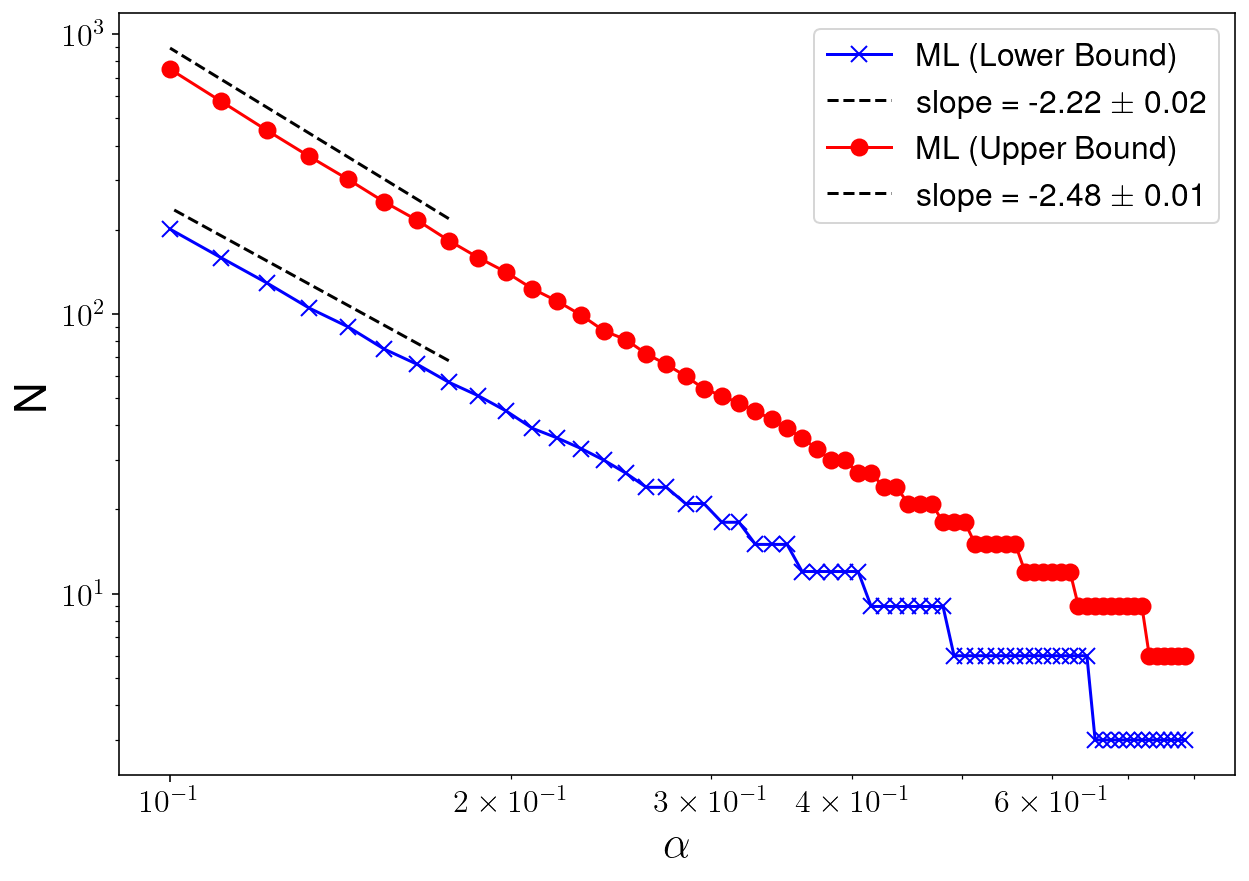

In [32]:
# Here, we just plot the trends of lower bound and upper bounds on the number of queries N required
# Lower bound is determined by analysis of the KL divergence of probability of target 
# Upper bound is determined through the Chernoff-Information bound
n_strategies = 2
list_alpha_array = [theta1_array, theta1_array]
list_N_array = [N_array_d5_lb, N_array_d5_ub]
list_n_iters = [8,8]
list_strategy_names = ['ML (Lower Bound)', 'ML (Upper Bound)']

plot_comparisons(n_strategies, list_alpha_array, list_N_array, list_strategy_names, list_n_iters=list_n_iters, 
                 FLAG_savefig=True, savefig_filename='comparison_bounds_ML_estimator.png')

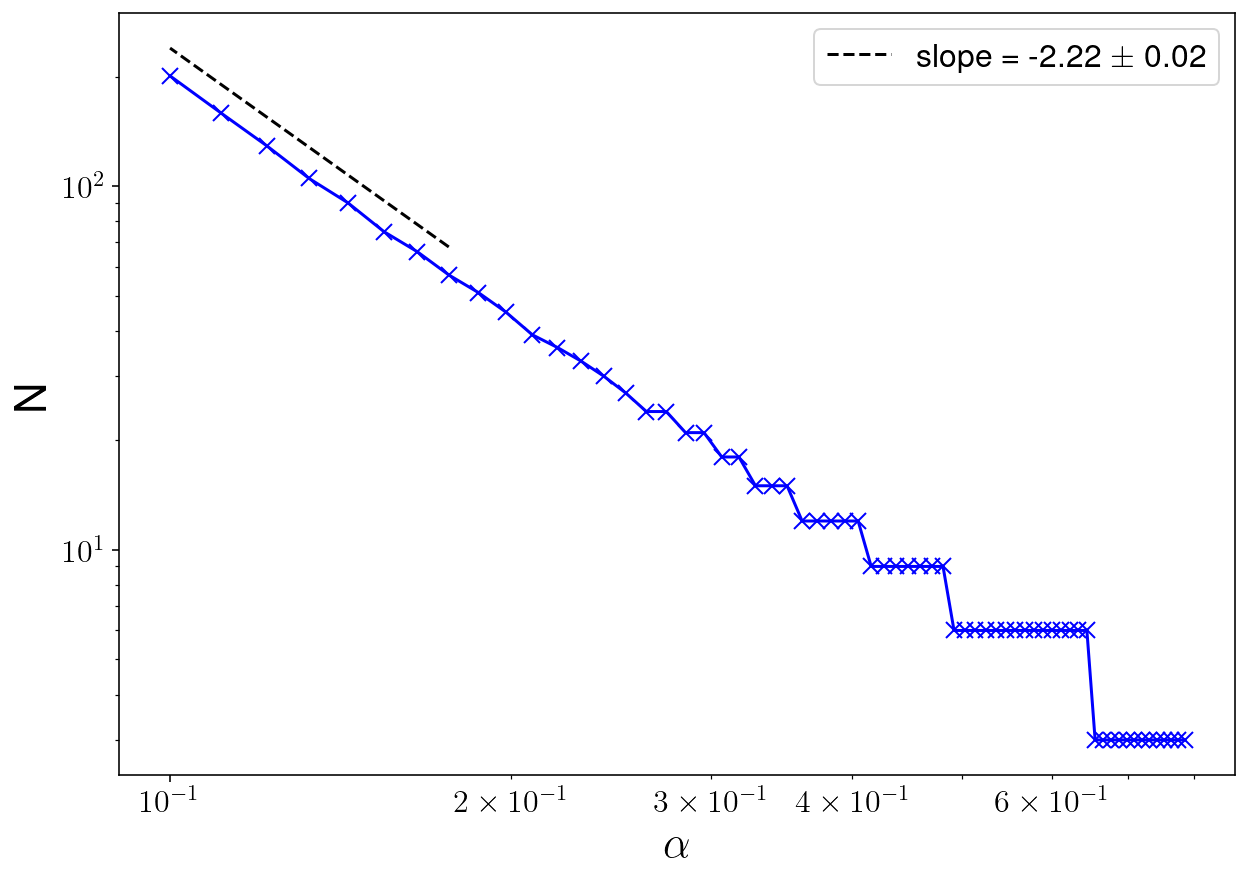

In [33]:
# Trend of experimental result 
plot_trend(theta1_array, N_array_d5_lb, n_iters_end=8, FLAG_savefig=True, savefig_filename='multishot_d3_eps_decimal05.png')

## Comparison of single-shot probabilities

In [29]:
alpha = 0.6

n_reps = 10
d_blocks = 3

phi_opt, _ = repeated_search_initial_conditions2(alpha, d_blocks, n_reps)
hiddenbcd.estimators.error_likelihood_ratio_test(1, phi_opt, alpha, d_blocks, FLAG_kl=False, FLAG_optimize_gamma=True)

0.2496810037006458

In [63]:
# How does the single shot error probability change with alpha for a fixed depth
n_reps = 10
d_blocks = 3

alpha_array = np.linspace(0.1, np.pi / 4, 64)
alpha_array = np.flip(alpha_array)    # Go in ascending order of difficulty

n_alpha = len(alpha_array)
error_single_shot = np.zeros(n_alpha)
error_single_shot_lb_LRT = np.zeros(n_alpha)
error_single_shot_chernoff_LRT = np.zeros(n_alpha)
error_single_shot_chernoff_opt_LRT = np.zeros(n_alpha)

for ind in range(n_alpha):
    alpha_temp = alpha_array[ind]
    phi_opt, _ = repeated_search_initial_conditions2(alpha_temp, d_blocks, n_reps)

    error_single_shot[ind] = hiddenbcd.estimators.error_majority_vote(1, phi_opt, alpha_temp, d_blocks)
    error_single_shot_lb_LRT[ind] = hiddenbcd.estimators.error_likelihood_ratio_test(1, phi_opt, alpha_temp, d_blocks)
    error_single_shot_chernoff_LRT[ind] = hiddenbcd.estimators.error_likelihood_ratio_test(1, phi_opt, alpha_temp, d_blocks, FLAG_kl=False)
    error_single_shot_chernoff_opt_LRT[ind] = hiddenbcd.estimators.error_likelihood_ratio_test(1, phi_opt, alpha_temp, d_blocks, 
                                                                                  FLAG_kl=False, FLAG_optimize_gamma=True,
                                                                                  FLAG_verbose=True)
    print(ind)

gamma=0.351608
0
gamma=0.349755
1
gamma=0.348004
2
gamma=0.346347
3
gamma=0.344780
4
gamma=0.343298
5
gamma=0.341905
6
gamma=0.340575
7
gamma=0.339323
8
gamma=0.338145
9
gamma=0.337034
10
gamma=0.335991
11
gamma=0.335013
12
gamma=0.334098
13
gamma=0.333247
14
gamma=0.332455
15
gamma=0.331725
16
gamma=0.331053
17
gamma=0.330441
18
gamma=0.329886
19
gamma=0.329390
20
gamma=0.328950
21
gamma=0.328569
22
gamma=0.328245
23
gamma=0.327980
24
gamma=0.327770
25
gamma=0.327621
26
gamma=0.327530
27
gamma=0.327499
28
gamma=0.327529
29
gamma=0.327620
30
gamma=0.327774
31
gamma=0.327992
32
gamma=0.328278
33
gamma=0.328630
34
gamma=0.329050
35
gamma=0.329541
36
gamma=0.330106
37
gamma=0.330749
38
gamma=0.331471
39
gamma=0.332276
40
gamma=0.333169
41
gamma=0.334153
42
gamma=0.335231
43
gamma=0.336418
44
gamma=0.337703
45
gamma=0.339111
46
gamma=0.340633
47
gamma=0.342291
48
gamma=0.344090
49
gamma=0.346043
50
gamma=0.348149
51
gamma=0.350452
52
gamma=0.352946
53
gamma=0.355653
54
gamma=0.358609
55
ga

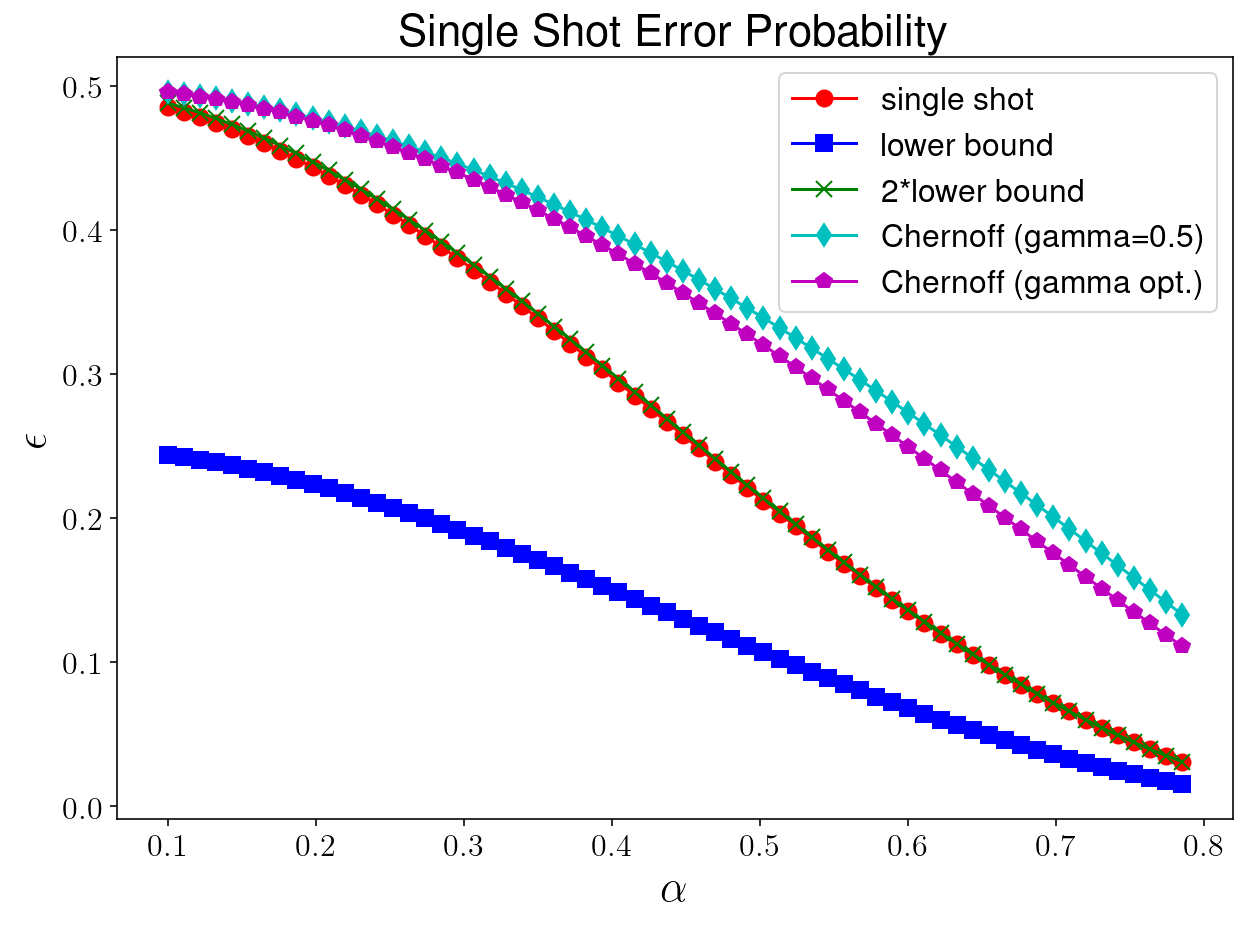

In [64]:
plt.figure(figsize=(10,7))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.plot(alpha_array, error_single_shot, '-o', c='r', markersize=8, label='single shot')
plt.plot(alpha_array, error_single_shot_lb_LRT, '-s', c='b', markersize=8, label='lower bound')
plt.plot(alpha_array, 2*error_single_shot_lb_LRT, '-x', c='g', markersize=8, label='2*lower bound')
plt.plot(alpha_array, error_single_shot_chernoff_LRT, '-d', c='c', markersize=8, label='Chernoff (gamma=0.5)')
plt.plot(alpha_array, error_single_shot_chernoff_opt_LRT, '-p', c='m', markersize=8, label='Chernoff (gamma opt.)')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\epsilon$')
#plt.yscale('log')
#plt.xscale('log')
plt.legend(loc='upper right')
plt.title('Single Shot Error Probability')
plt.savefig('single_shot_error_probability.png', dpi=150, bbox_inches='tight')

# Note on experimental procedure for multi-shot protocol

As described in the supplementary material accompanying the paper, we need to repeat the experiments using multi-shot protocol multiple times to output an expected value of $N$ to solve a given $\textsf{HBCD}(\alpha, \epsilon, \rho_h)$ with high confidence.

The number of independent repetitions of these experiments are determined here for outputting $N$ with $90\%$ or $95\%$ confidence.

In [7]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [80]:
epsilon = 0.05
L_array = np.arange(10,100)
pconf_array = np.zeros(len(L_array))

for ind in range(len(L_array)):
    L = L_array[ind]
    pconf_array[ind] = scipy.stats.beta.cdf(1,L,1) - scipy.stats.beta.cdf(1-epsilon,L,1)

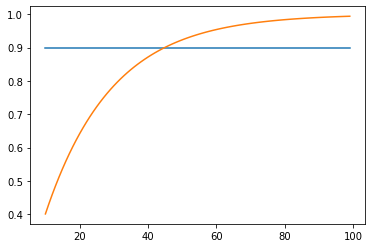

In [81]:
plt.plot(L_array, 0.9*np.ones(len(L_array)))
plt.plot(L_array, pconf_array)

In [84]:
np.min(L_array[np.where(pconf_array >= 0.9)])

45

In [85]:
np.min(L_array[np.where(pconf_array >= 0.95)])

59

In [90]:
epsilon = 0.025
L_array = np.arange(10,1500)
pconf_array = np.zeros(len(L_array))

for ind in range(len(L_array)):
    L = L_array[ind]
    pconf_array[ind] = scipy.stats.beta.cdf(1,L,1) - scipy.stats.beta.cdf(1-epsilon,L,1)

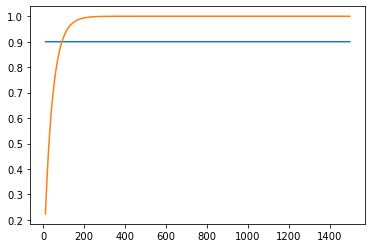

In [91]:
plt.plot(L_array, 0.9*np.ones(len(L_array)))
plt.plot(L_array, pconf_array)

In [92]:
np.min(L_array[np.where(pconf_array >= 0.9)])

91

In [93]:
np.min(L_array[np.where(pconf_array >= 0.95)])

119

In [86]:
epsilon = 0.005
L_array = np.arange(10,1500)
pconf_array = np.zeros(len(L_array))

for ind in range(len(L_array)):
    L = L_array[ind]
    pconf_array[ind] = scipy.stats.beta.cdf(1,L,1) - scipy.stats.beta.cdf(1-epsilon,L,1)

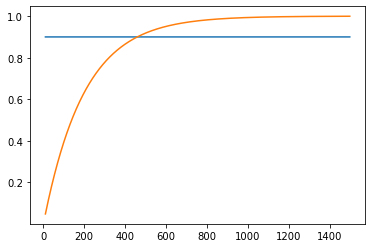

In [87]:
plt.plot(L_array, 0.9*np.ones(len(L_array)))
plt.plot(L_array, pconf_array)

In [88]:
np.min(L_array[np.where(pconf_array >= 0.9)])

460

In [89]:
np.min(L_array[np.where(pconf_array >= 0.95)])

598